In [2]:
import h5py
from utils import ParamsFile, HaloReader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.collections import LineCollection
from matplotlib.colors import LogNorm
from scipy.special import erf, erfinv
import importlib

import ps_toolkit as ps

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('font', size=15)

#from matplotlib.patches import Ellipse

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    
    Copied from: https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap/38219022
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.set_yscale('log')
    ax.set_xscale('log')
    return lc



def rho_u(z):
    '''Calculate density of the universe at redshift z
    '''
    a = 1/(z+1)
    x = a/a_eq
    rho_eq = 2.55e5*(1e6)**3
    return rho_eq*(x**(-3) + x**(-4))


In [5]:
# Cosmological parameters
Omega_m0 = 0.3
Omega_r0 = 8.486e-5
h = 0.7

G = 6.674e-11 # m^3 kg^(-1) s^(-2)
Mpc = 3.086e22 # m 
Msol = 1.988e30 # kg
Mpcpkm = (1e3/3.0869e22)
H = 100*Mpcpkm*h # /s
Omega_DM = 0.267

rho_c = 3/(8*np.pi*G)*Mpc**3/Msol*H**2 # Msol / Mpc^(-3)
rho_bg = 0.267*rho_c

rho_bg = 8.66e+10 # FROM PEAK PATCH

print("rho_bg = {:.3}".format(rho_bg))
z_eq = Omega_m0/Omega_r0 - 1
a_eq = 1/(1+z_eq)

rho_eq = Omega_m0*(a_eq)**3

print("z_eq = {:.5}".format(z_eq))

rho_bg = 8.66e+10
z_eq = 3534.2


In [6]:
# Load in the power spectrum
FilePath = "axionPS.dat"
k, Pf, blah, blah= np.loadtxt(FilePath).T

kdata = k/h
Pdata = Pf*h**3

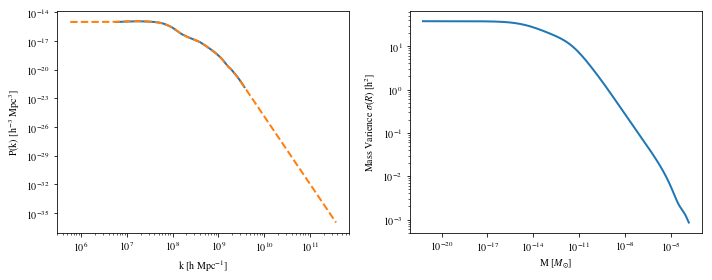

In [7]:
z = 99
HMF_PS, M, f_PS, sigma, iterpdata = ps.PS_HMF(Pdata, kdata, z=z, mode = 'PS')
pspec, k2 = iterpdata

# Plot powerspectrum
fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(121)
ax1.loglog(kdata[Pdata>0]*h, Pdata[Pdata>0]/h**3, '-',lw=2)
ax1.loglog(k2*h, pspec.val(k2)/h**3, '--',lw=2)
ax1.set_xlabel("k [h Mpc$^{-1}$]")
ax1.set_ylabel("P(k) [h$^{-3}$ Mpc$^{3}$]")

# Plot Mass Varience
ax2 = fig.add_subplot(122)
ax2.loglog(M, sigma*h**2,'-',linewidth=2)
ax2.set_ylabel("Mass Varience $\sigma(R)$ [h$^2$]")
ax2.set_xlabel("M [$M_{\odot}$]")
plt.tight_layout()

#np.save("FinalGraphs/Data/PowerSpec.npy",[k[Pf>0]*h, Pf[Pf>0]/h**3, M, sigma*h**2])

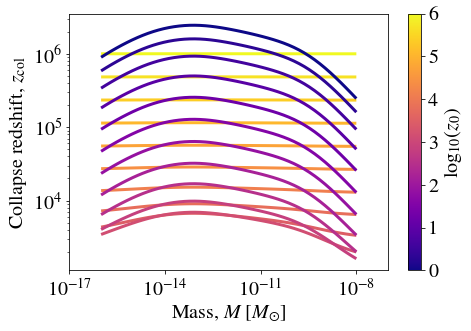

In [29]:
zs = np.logspace(6, 0, 20)
masses = np.logspace(-16,-8)

ys = np.array([ps.Find_zcol(Pdata, kdata, masses, z) for z in zs])
xs = np.array([masses for z in zs]) # could also use np.tile

matplotlib.rc('font', size=20)
fig = plt.figure(figsize = (7, 5))
ax1 = fig.add_subplot(111)
lc1 = multiline(xs, ys, np.log10(zs), ax = ax1, cmap='plasma', lw=3)
ax1.set_xlim(1e-17, 1e-7)
ax1.set_ylabel("Collapse redshift, $z_{\mathrm{col}}$")
ax1.set_xlabel("Mass, $M$ [$M_{\odot}$]")
axcb = fig.colorbar(lc1)
axcb.set_label('$\log_{10}(z_{0})$')

plt.tight_layout()
#fig.savefig("./figures/PS_zcol.pdf")

<h2>Fit $k(f)$ to data using least squares fit</h2>

In [52]:
from scipy.optimize import curve_fit
importlib.reload(ps)

nbodyx = [163e-11, 3.5e-11, 0.8e-11]
nbodyy = [160, 400, 450]    
    
pspec = [Pdata, kdata]    
    
def NFW_concSolve(mass, C):
    return ps.pred_conc(mass, C, 99, mode = "NFW",pspec=pspec, f=0.01)

def Bullock_concSolve(mass, C):
    return ps.pred_conc(mass, C, 99, mode = "Bullock", pspec=pspec, f = 0.00001)
    
popt2, pcov2 = curve_fit(Bullock_concSolve, nbodyx, nbodyy, p0 = 1)
print("k_Bullock = {:.3}".format(popt2[0]))

popt3, pcov3 = curve_fit(NFW_concSolve, nbodyx, nbodyy, p0 = 1)
print("k_NFW = {:.3}".format(popt3[0]))

k_Bullock = 0.214
k_NFW = 1.57


<h2>Predict C(M) using Bullock</h2>

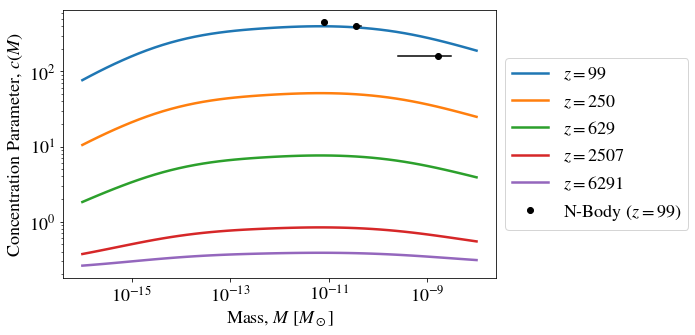

In [37]:
k_Bullock = 0.214

masses = np.logspace(-16,-8)
zs = np.sort([99, 250, 629, 2507, 6291])
ys = np.array([ps.pred_conc(masses, k_Bullock, z, 
                            pspec = [Pdata, kdata], mode="Bullock", f=0.00001) for z in zs])
xs = np.array([masses for z in zs]) # could also use np.tile

# Prepare Figure
matplotlib.rc('font', size=18)
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(111)

# Plot each line
for i,z in enumerate(zs):
    ax1.loglog(masses, ys[i], lw = 2.5, label = "$z = {}$".format(z))

# Plot N-Body results
ax1.loglog([163e-11, 3.5e-11, 0.8e-11], [160, 400, 450],'ko', label = "N-Body ($z = 99$)")
ax1.loglog([26e-11, 300e-11], [160,160],'k-')
ax1.loglog([3.4e-11, 4.6e-11], [400,400],'k-')

# Add labels and legend
ax1.set_ylabel("Concentration Parameter, $c(M)$")
ax1.set_xlabel("Mass, $M$ [$M_{\odot}$]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax1.set_xlabel(r"Mass, $M$ [$M_\odot$]")
plt.tight_layout()

#np.save("./FinalGraphs/Data/PSconcBullock.npy",[xs[0], zs, ys])

<h2>Predict C(M) using NFW2</h2>
New (possibly corrected) NFW equation

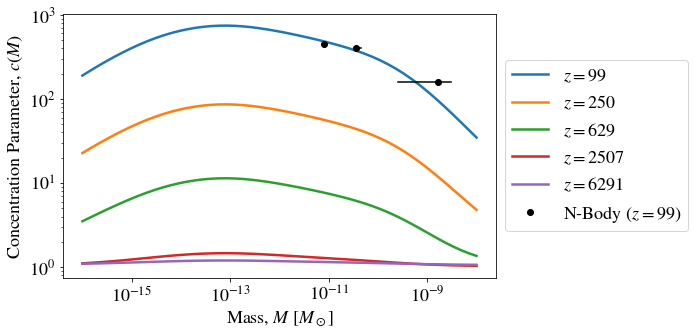

In [40]:
k_NFW = 1.57

masses = np.logspace(-16,-8)
zs = np.sort([99, 250, 629, 2507, 6291])
ys = np.array([ps.pred_conc(masses, k_NFW, z, 
                            pspec = [Pdata, kdata], mode="NFW", f=0.01) for z in zs])
xs = np.array([masses for z in zs]) # could also use np.tile

# Prepare Figure
matplotlib.rc('font', size=18)
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(111)

# Plot each line
for i,z in enumerate(zs):
    ax1.loglog(masses, ys[i], lw = 2.5, label = "$z = {}$".format(z))

# Plot N-Body results
ax1.loglog([163e-11, 3.5e-11, 0.8e-11], [160, 400, 450],'ko', label = "N-Body ($z = 99$)")
ax1.loglog([26e-11, 300e-11], [160,160],'k-')
ax1.loglog([3.4e-11, 4.6e-11], [400,400],'k-')

# Add labels and legend
ax1.set_ylabel("Concentration Parameter, $c(M)$")
ax1.set_xlabel("Mass, $M$ [$M_{\odot}$]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax1.set_xlabel(r"Mass, $M$ [$M_\odot$]")
plt.tight_layout()

#np.save("./FinalGraphs/Data/PSconcNFW.npy",[xs[0], zs, ys])

<h2>Plotting PS HMF</h2>

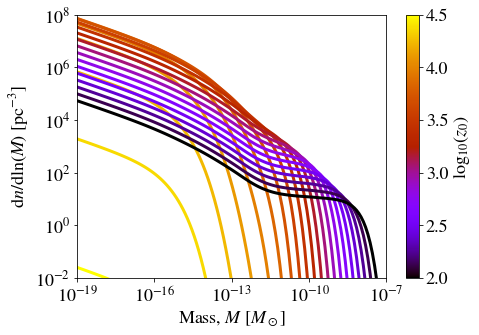

In [43]:
# Create data arrays
zs = np.logspace(4.5, 2, 20)
ys = np.array([ps.PS_HMF(Pf, k, z=z, mode = 'PS')[0] for z in zs])
xs = np.array([M for z in zs])

fig = plt.figure(figsize = (7, 5))
ax1 = fig.add_subplot(111)
lc1 = multiline(xs, ys*(1e-6)**3, np.log10(zs), ax = ax1, cmap='gnuplot', lw=3)
ax1.set_ylim(1e-2, 1e8)
ax1.set_xlim([1e-19, 1e-7])
axcb = fig.colorbar(lc1)
axcb.set_label('$\log_{10}(z_{0})$')
ax1.set_xlabel(r"Mass, $M$ [$M_\odot$]")
ax1.set_ylabel(r"$\mathrm{d}n/\mathrm{d }\ln(M)$ [pc$^{-3}$]")
plt.tight_layout()
#plt.savefig("./figures/PS_HMF.pdf")

<h2>PS $N_{\mathrm{tot}}$ prediction</h2>

In [ ]:
redshifts = np.logspace(6, 2, 50)
Vol = 0.645 # pc^3

cut_off_masses = np.array([1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10])
Mtot = 86618943523 # M_sol

fb = ps.massfrac([Pdata, kdata], redshifts, Mtot, mode = "PS")
HaloNums = ps.haloNums([Pdata, kdata], redshifts, Vol, cutoffmasses = cut_off_masses, mode = "PS")

matplotlib.rc('font', size=18)
fig1 = plt.figure(figsize = (7, 6))

ax1 = fig1.add_subplot(8,2,(1,6))
ax1.semilogx(redshifts, fb, lw=2.5)
ax1.set_xlim(max(redshifts), min(redshifts))
ax1.set_ylim(-0.1, 1)
ax1.set_xticks([])
ax1.set_ylabel("$f_b$")

ax2 = fig1.add_subplot(8,2,(7,16))
for i, N in enumerate(HaloNums): 
    ax2.loglog(redshifts, N, lw = 2.5)

# z_eq line
ax2.loglog([z_eq,z_eq], [1e-2, 1e7],'k--', lw = 2)

ax2.set_ylabel("$N_{\mathrm{tot}}$")
ax2.set_xlabel("Redshift, $z$")
ax2.set_xlim(max(redshifts), min(redshifts))
ax2.set_ylim(1, 1e7)
ax2.legend(["$M>10^{-15}M_{\odot}$", "$M>10^{-14}M_{\odot}$", "$M>10^{-13}M_{\odot}$", 
          "$M>10^{-12}M_{\odot}$", "$M>10^{-11}M_{\odot}$", "$M>10^{-10}M_{\odot}$"], prop={'size': 14},loc=2)
plt.tight_layout()

#plt.savefig("figures/PSmassFrac.pdf")
#np.save("FinalGraphs/Data/HaloNumsPS.npy",[redshifts, HaloNums, fb])

<h2>Compare to m3p</h2>

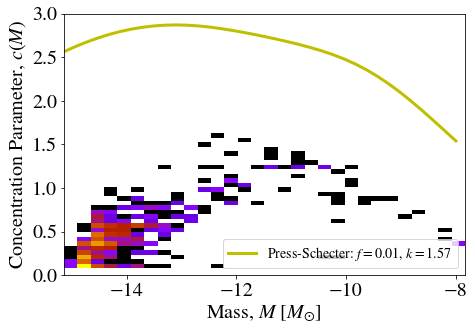

In [23]:
importlib.reload(ps)

collapse_redshifts = np.load("ConcEvolution/axbig_manyz_CollapseRedshifts_f1em2_z0_100.0.npy", allow_pickle = True)
masses = np.load("ConcEvolution/axbig_manyz_FinalMasses_f1em2_z0_100.0.npy", allow_pickle = True)

masses = masses[collapse_redshifts>200]
collapse_redshifts = collapse_redshifts[collapse_redshifts>200]

k_NFW = 1.57 # From PS estimate + least squares to N-Body

concs = ps.pred_conc(masses, k_NFW, 99, zcol = collapse_redshifts, mode = "NFW", f = 0.01)

matplotlib.rc('font', size=20)
plt.figure(figsize = (7,5))
plt.hist2d(np.log10(masses), np.log10(concs), bins = 30, norm=LogNorm(), cmap = 'gnuplot');
plt.ylim(0, 3)
x = np.logspace(-18,-8)
y = ps.pred_conc(x, C, 99, mode = "NFW", f = 0.01, pspec=[Pdata,kdata])
plt.plot(np.log10(x), np.log10(y), 'y-', lw = 3, label = "Press-Schecter: $f=0.01$, $k={}$".format(C))

plt.legend(prop={'size': 14}, loc=4)
plt.xlabel("Mass, $M$ [$M_{\odot}$]");
plt.ylabel("Concentration Parameter, $c(M)$");
plt.tight_layout()
#plt.savefig("./figures/conc_m3p_comp.pdf")

In [10]:
def bin2d(x, y, bins, log = False):
    if type(bins) != int and type(bins) != np.ndarray:
        print("Error: bins must be int or array!")
    
    if type(bins) == int:
        if log == False:
            bins = np.linspace(min(x), max(x), bins)
        elif log == True:
            bins = np.logspace(np.log10(min(x)),np.log10(max(x)), bins)

    mid = np.asarray([np.percentile(y[(x>bins[i])*(x<bins[i+1])], 50) for i in range(len(bins)-1)])
    upper = np.asarray([np.percentile(y[(x>bins[i])*(x<bins[i+1])],75) for i in range(len(bins)-1)])
    lower = np.asarray([np.percentile(y[(x>bins[i])*(x<bins[i+1])],25) for i in range(len(bins)-1)])
    
    ymax = np.asarray([max(y[(x>bins[i])*(x<bins[i+1])]) for i in range(len(bins)-1)])
    ymin = np.asarray([min(y[(x>bins[i])*(x<bins[i+1])]) for i in range(len(bins)-1)])
    return mid, upper, lower,ymax, ymin, bins

def many_hist(x, y, xbins, ybins, xlog = False, ylog = False):
    '''
    Returns histogram of y within each bin 
    '''
    
    # Check xbin type
    if type(xbins) != int and type(xbins) != np.ndarray:
        print("Error: bins must be int or array!")
    # Check ybin type
    if type(ybins) != int and type(ybins) != np.ndarray:
        print("Error: bins must be int or array!")
        
    #### If only the number of bins given calculate the bin array #####
    # For x:
    if type(xbins) == int:
        if xlog == False:
            xbins = np.linspace(min(x), max(x), xbins)
        elif xlog == True:
            xbins = np.logspace(np.log10(min(x)),np.log10(max(x)), xbins)
            
    # For y:    
    if type(ybins) == int:
        if ylog == False:
            ybins = np.linspace(min(y), max(y), ybins)
        elif ylog == True:
            ybins = np.logspace(np.log10(min(y)),np.log10(max(y)), ybins)      
    
    # Calculate histograms
    hists = [np.histogram(y[(x>xbins[i])*(x<xbins[i+1])], bins = ybins)[0] for i in range(len(xbins)-1)]
    
    return hists, xbins, ybins

## Comparing m3p and PS prediction

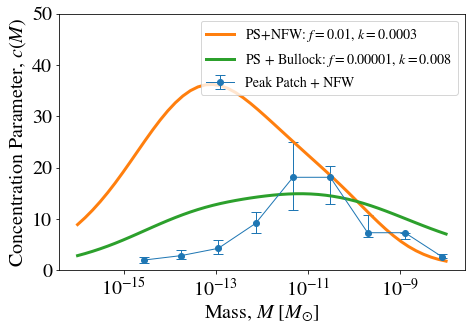

In [32]:
mid, upper, lower,ymax, ymin, bins = bin2d(masses, concs, 10, log=True)
plt.figure(figsize = (7,5))
plt.errorbar((bins[1:]+bins[:-1])/2, mid, yerr=(mid-lower,upper-mid), marker = 'o', lw = 1,capsize = 5, label = "Peak Patch + NFW")
#plt.plot(, mid)

# NFW2 C(M) fit
k_NFW = 3e-4 # Normalisation
x = np.logspace(-16,-8)
y = ps.pred_conc(x, k_NFW, 99, mode = "NFW", f = 0.01,pspec=[Pdata,kdata])
plt.plot(x, y, lw = 3, label = "PS+NFW: $f=0.01$, $k={:.3}$".format(k_NFW))

# Bullock C(M) fit
k_Bullock = 8e-3 # Normalisation
x = np.logspace(-16,-8)
y = ps.pred_conc(x, k_Bullock, 99, mode = "Bullock", f = 0.00001,pspec=[Pdata,kdata])
plt.plot(x, y, lw = 3, label = "PS + Bullock: $f=0.00001$, $k={:.3}$".format(k_Bullock))


plt.xscale('log')
#plt.yscale('log')
plt.ylim(0, 50)
plt.legend(prop={'size': 14})
plt.xlabel("Mass, $M$ [$M_{\odot}$]");
plt.ylabel("Concentration Parameter, $c(M)$");
plt.tight_layout()
#plt.savefig("./figures/conc_m3p_comp.pdf")

## Compare f=0 and f=0.01

(1e-16, 2e-08)

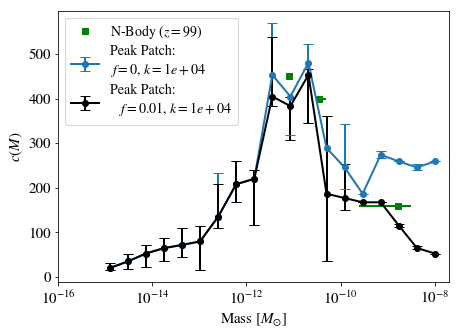

In [52]:
plt.figure(figsize = (7,5))

zColFile1 = "ConcEvolution/axbig_manyz_CollapseRedshifts_f0_z0_100.0.npy"
zColFile2 = "ConcEvolution/axbig_manyz_CollapseRedshifts_f1em2_z0_100.0.npy"

massesFile = "ConcEvolution/axbig_manyz_FinalMasses_f0_z0_100.0.npy"

allmid = []
allup = []
alllow = []

f_vals = [0.0, 0.01, 0.1]

##### f = 0 #####
masses = np.load(massesFile, allow_pickle=True)
collapse_redshifts = np.load(zColFile1, allow_pickle=True)
masses = masses[collapse_redshifts>150]
collapse_redshifts = collapse_redshifts[collapse_redshifts>150]
k_pp_nfw = 1e4 # Normalisation
concs = ps.pred_conc(masses, k_pp_nfw, 99, zcol = collapse_redshifts, mode = "NFW", f = 0.01)
mid, upper, lower, ymax, ymin, bins = bin2d(masses, concs, 20, log=True)
plt.errorbar((bins[1:]+bins[:-1])/2, mid, yerr=(mid-lower,upper-mid), marker = 'o',
             lw = 2,capsize = 5, label = "Peak Patch:\n$f = 0$, $k={:.3}$".format(k_pp_nfw))

allmid.append(mid)
allup.append(upper)
alllow.append(lower)

##### f = 0.01 #####
masses = np.load(massesFile, allow_pickle=True)
collapse_redshifts = np.load(zColFile2, allow_pickle=True)

masses = masses[collapse_redshifts>150]
collapse_redshifts = collapse_redshifts[collapse_redshifts>150]

k_pp_nfw = 1e4 # Normalisation
concs = ps.pred_conc(masses, k_pp_nfw, 99, zcol = collapse_redshifts, mode = "NFW", f = 0.01)
mid, upper, lower, ymax, ymin, bins = bin2d(masses, concs, 20, log=True)
plt.errorbar((bins[1:]+bins[:-1])/2, mid, yerr=(mid-lower,upper-mid), color = "black", marker = 'o',
             lw = 2,capsize = 5, label = "Peak Patch:\n   $f = 0.01$, $k={:.3}$".format(k_pp_nfw))

# N-Body
plt.plot([163e-11, 3.5e-11, 0.8e-11], [160, 400, 450],'gs', label = "N-Body ($z = 99$)")
plt.plot([26e-11, 300e-11], [160,160],'g-', lw = 2)
plt.plot([3.4e-11, 4.6e-11], [400,400],'g-', lw = 2)

plt.legend(prop={'size': 14})
plt.xlabel("Mass [$M_{\odot}$]")
plt.ylabel("$c(M)$")
plt.xscale('log')
plt.xlim((1e-16, 2e-8))
#plt.yscale('log')

#np.save("FinalGraphs/Data/PeakPatchConcs.npy",[(bins[1:]+bins[:-1])/2, allmid, allup, alllow, f_vals])


<h3>$C(M)$ Histogram</h3>

In [ ]:
matplotlib.rc('font', size=18)

# f = 0.01
masses = np.load("axbig_manyz_FinalMasses_f1em2.npy", allow_pickle=True)
collapse_redshifts = np.load("axbig_manyz_CollapseRedshifts_f1em2.npy", allow_pickle=True)


masses = masses[collapse_redshifts>200]
collapse_redshifts = collapse_redshifts[collapse_redshifts>200]
C = 2e-15 # Normalisation
del_char = C*rho_u(collapse_redshifts)
concs = solve_conc(del_char)
hists, xbins, ybins = many_hist(masses, concs, 7, np.linspace(min(concs), 600, 15), xlog=True, ylog = True)

fig = plt.figure(figsize = (10,10))
for i in range(len(xbins)-1):
    ax = fig.add_subplot(int(len(xbins)/2),2,i+1)
    #ax.plot(ybins[:-1], hists[i]/np.diff(ybins), lw = 3, label = "M ~ {:.3}$M_☉$".format(xbins[i]));
    ax.bar(ybins[:-1], hists[i]/np.diff(ybins), lw = 3, width = np.diff(ybins), label = "M ~ {:.3}$M_☉$".format(xbins[i]));
    if i < 2:
        ax.set_ylim(0, 8)
    else:
        ax.set_ylim(0, 0.6)
    ax.set_xlim(15, 600)
    if i < len(xbins)-3:
        ax.set_xticks([])
    if i % 2 != 0:
        ax.set_yticks([])
    if i % 2 == 0:
        plt.ylabel(r"$\frac{n}{\Delta c(M)}$")
    if i >= len(xbins)-3:
        plt.xlabel("$c(M)$")
    plt.legend(prop={'size': 14})
plt.tight_layout()
plt.savefig("figures/cM_hists.pdf")
plt.show()

hists, xbins, ybins = many_hist(masses, collapse_redshifts, 9, 30, xlog=True, ylog = True)

fig = plt.figure(figsize = (10,10))
for i in range(len(xbins)-1):
    ax = fig.add_subplot(int(len(xbins)/2),2,i+1)
    ax.loglog(ybins[:-1],hists[i], lw = 3, label = "M ~ {:.3}$M_☉$".format(xbins[i]));
    ax.set_ylim(9e-1, 100)
    if i < len(xbins)-3:
        ax.set_xticks([])
    if i % 2 != 0:
        ax.set_yticks([])
    if i % 2 == 0:
        plt.ylabel("n")
    if i >= len(xbins)-3:
        plt.xlabel("$z_{col}$")
    plt.legend(prop={'size': 14})
plt.tight_layout()
plt.savefig("figures/xCol_hists.pdf")
plt.show()

## C(M) Evolution

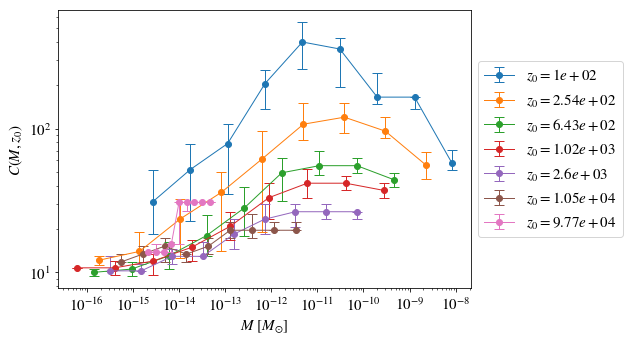

In [48]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('font', size=15)

startIndicies = [0, 10, 20, 25, 35, 50, 74]
plt.figure(figsize = (9,5))
allmid = []
allup = []
alllow = []
allmasses = []
for i, startIndex in enumerate(startIndicies):  
    z0 = np.logspace(2,6,100)[startIndex]
    collapse_redshifts = np.load("ConcEvolution/axbig_manyz_CollapseRedshifts_f1em2_z0_{}.npy".format(z0), allow_pickle = True)
    masses = np.load("ConcEvolution/axbig_manyz_FinalMasses_f1em2_z0_{}.npy".format(z0), allow_pickle = True)
    
    # Take out halos with collapse redshifts too close to z0
    masses = masses[collapse_redshifts> z0 + 50]
    collapse_redshifts = collapse_redshifts[collapse_redshifts> z0 + 50]
    
    k_NFW = 1.5 # Normalisation
    concs = ps.pred_conc(masses, k_pp_nfw, z0, zcol = collapse_redshifts, mode = "NFW", f = 0.01)
    
    mid, upper, lower, ymax, ymin, bins  = bin2d(masses, concs, 10, log=True)
    allmid.append(mid)
    allup.append(upper)
    alllow.append(lower)
    plt.errorbar((bins[1:]+bins[:-1])/2, mid, yerr=(mid-lower,upper-mid), marker = 'o', 
                 lw = 1,capsize = 5, label = "$z_0 = {:.3}$".format(z0))
    allmasses.append((bins[1:]+bins[:-1])/2)
plt.ylabel("$C(M,z_0)$")
plt.xlabel("$M$ [$M_{\odot}$]")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.tight_layout()
#plt.savefig("figures/conEvo.pdf")

#np.save("FinalGraphs/Data/PeakPatchConcEvoNFW.npy",[allmasses, allmid, allup, alllow, np.logspace(2,6,100)[startIndicies]])

In [ ]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('font', size=15)

startIndicies = [0, 10, 20, 25, 35, 50, 74]
plt.figure(figsize = (9,5))
allmid = []
allup = []
alllow = []
allmasses = []

C = 11 # Normalisation

for i, startIndex in enumerate(startIndicies):  
    z0 = np.logspace(2,6,100)[startIndex]
    collapse_redshifts = np.load("ConcEvolution/axbig_manyz_CollapseRedshifts_f1em2_z0_{}.npy".format(z0), allow_pickle = True)
    masses = np.load("ConcEvolution/axbig_manyz_FinalMasses_f1em2_z0_{}.npy".format(z0), allow_pickle = True)
    
    concs =  C*(rho_u(collapse_redshifts[collapse_redshifts> z0 + 50])/rho_u(z0))**(1/3)
    masses = masses[collapse_redshifts> z0 + 50]
    
    mid, upper, lower, ymax, ymin, bins  = bin2d(masses, concs, 10, log=True)
    allmid.append(mid)
    allup.append(upper)
    alllow.append(lower)
    plt.errorbar((bins[1:]+bins[:-1])/2, mid, yerr=(mid-lower,upper-mid), marker = 'o', 
                 lw = 1,capsize = 5, label = "$z_0 = {:.3}$".format(z0))
    allmasses.append((bins[1:]+bins[:-1])/2)
    
plt.loglog([163e-11, 3.5e-11, 0.8e-11], [160, 400, 450],'ko', label = "N-Body ($z = 99$)")
plt.loglog([26e-11, 300e-11], [160,160],'k-')
plt.loglog([3.4e-11, 4.6e-11], [400,400],'k-')    
    
plt.ylabel("$C(M,z_0)$")
plt.xlabel("$M$ [$M_{\odot}$]")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.tight_layout()
plt.savefig("figures/conEvo.pdf")

#np.save("FinalGraphs/Data/PeakPatchConcEvoBullock.npy",[allmasses, allmid, allup, alllow, np.logspace(2,6,100)[startIndicies]])

<h2>Calcuate final PS HMF for PS, ST and TK</h2>

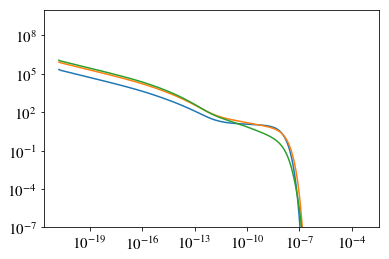

In [28]:
z = 99

HMF_PS, M, f_PS, sigma, blah = ps.PS_HMF(Pf, k, z=z, mode = 'PS')
HMF_ST, M, f_PS, sigma, blah = ps.PS_HMF(Pf, k, z=z, mode = 'ST')
HMF_TK, M, f_PS, sigma, blah = ps.PS_HMF(Pf, k, z=z, mode = 'TK')

plt.loglog(M, HMF_PS*(1e-6)**3)
plt.loglog(M, HMF_ST*(1e-6)**3)
plt.loglog(M, HMF_TK*(1e-6)**3)

plt.ylim(1e-7, 1e10)

#np.save("FinalGraphs/Data/PSfinalHMF.npy", [M, HMF_PS*(1e-6)**3,HMF_ST*(1e-6)**3,HMF_TK*(1e-6)**3])